Index(['Age', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack',
       'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'MentHlth',
       'PhysHlth', 'DiffWalk', 'Stroke', 'HighBP', 'Diabetes', 'Sex_1.0',
       'GenHlth_1.0', 'GenHlth_2.0', 'GenHlth_3.0', 'GenHlth_4.0',
       'GenHlth_5.0'],
      dtype='object')
        Age  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0       4.0       0.0        1.0  26.0     0.0                   0.0   
1      12.0       1.0        1.0  26.0     1.0                   0.0   
2      13.0       0.0        1.0  26.0     0.0                   0.0   
3      11.0       1.0        1.0  28.0     1.0                   0.0   
4       8.0       0.0        1.0  29.0     1.0                   0.0   
...     ...       ...        ...   ...     ...                   ...   
70687   6.0       1.0        1.0  37.0     0.0                   0.0   
70688  10.0       1.0        1.0  29.0     1.0                   1.0   
70689  13

,Description,Value
0,Session id,123
1,Target,Diabetes
2,Target type,Binary
3,Original data shape,"(56553, 22)"
4,Transformed data shape,"(56553, 22)"
5,Transformed train set shape,"(39587, 22)"
6,Transformed test set shape,"(16966, 22)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7493,0.8261,0.7936,0.7294,0.7601,0.4985,0.5005,0.3530
gbc,Gradient Boosting Classifier,0.7487,0.8276,0.7855,0.7320,0.7578,0.4974,0.4987,0.4900
ada,Ada Boost Classifier,0.7477,0.8253,0.7725,0.7363,0.7540,0.4953,0.4959,0.1480
lr,Logistic Regression,0.7457,0.8229,0.7718,0.7340,0.7524,0.4915,0.4921,0.6340
ridge,Ridge Classifier,0.7457,0.8222,0.7778,0.7312,0.7538,0.4913,0.4923,0.0140
lda,Linear Discriminant Analysis,0.7457,0.8222,0.7778,0.7312,0.7538,0.4913,0.4923,0.0220
svm,SVM - Linear Kernel,0.7422,0.8198,0.7640,0.7337,0.7473,0.4844,0.4865,0.0310
nb,Naive Bayes,0.7240,0.7863,0.7240,0.7245,0.7242,0.4481,0.4481,0.0150
rf,Random Forest Classifier,0.7239,0.7940,0.7545,0.7114,0.7323,0.4477,0.4486,0.4360
knn,K Neighbors Classifier,0.7104,0.7695,0.7395,0.6992,0.7188,0.4207,0.4215,0.2170


[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=123, subsample=1.0, tol=0.0001,
                           

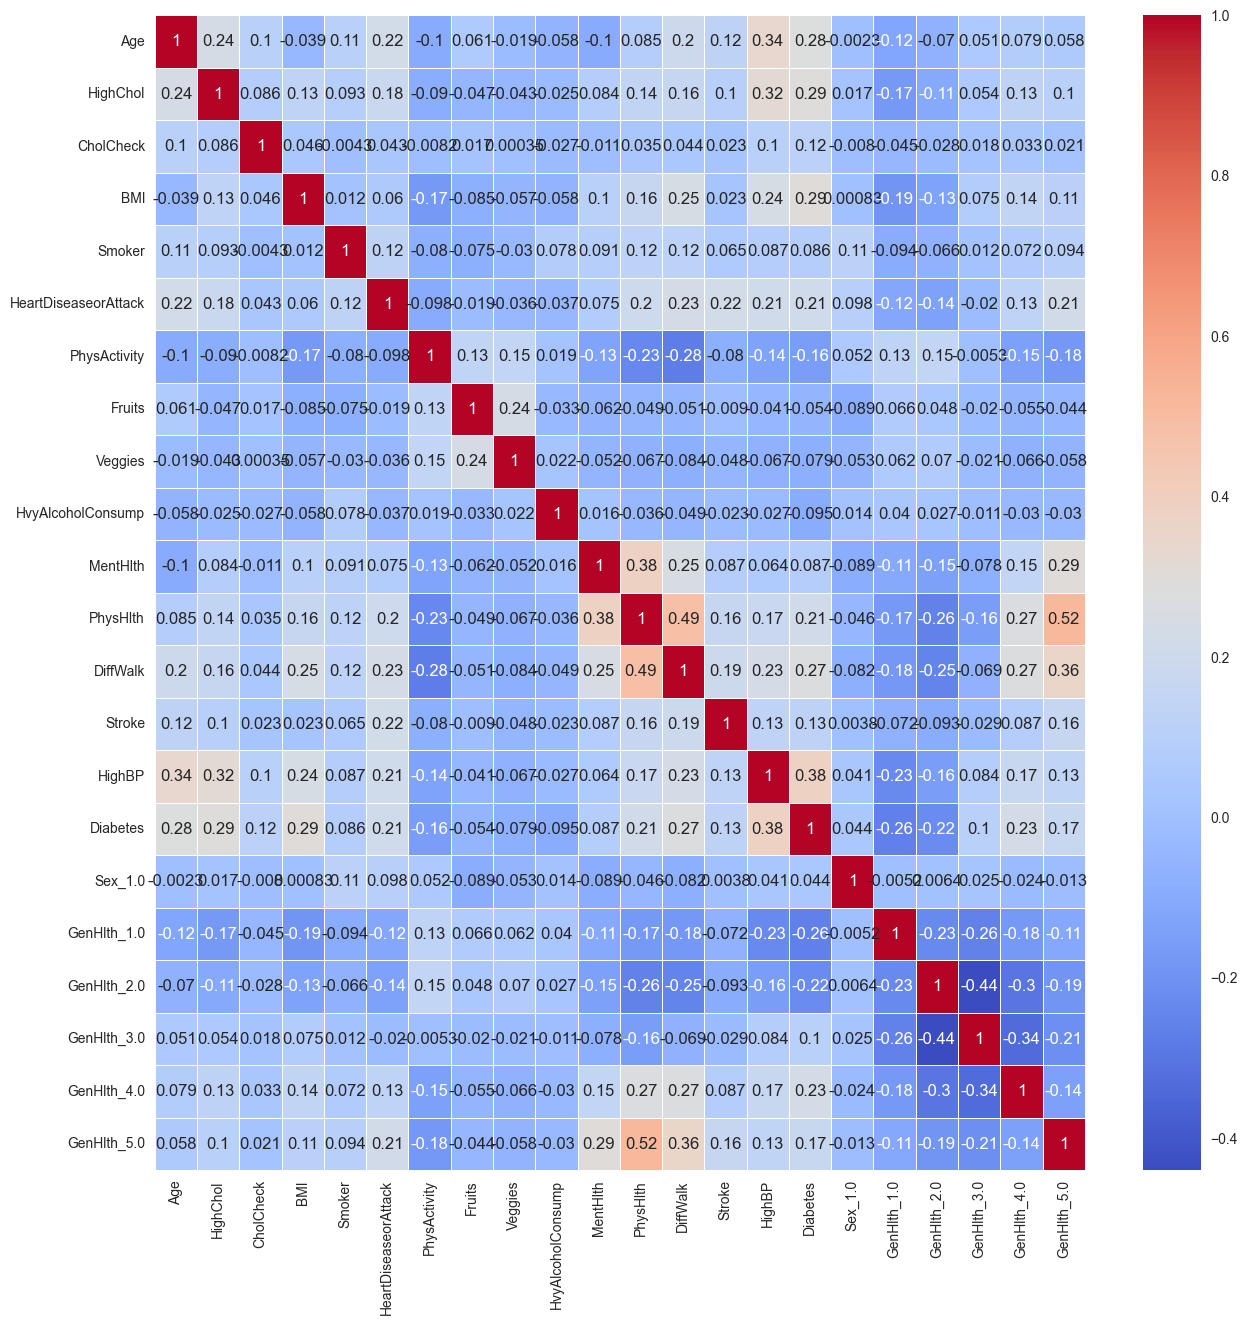

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *


# Read the data into a pandas dataframe
df = pd.read_csv("diabetes_data.csv")

# One hot encoding, dropfirst to remove the redundant column, since for sex they will have perfect negative corrolation (e.g. is_female and is_male)
df = pd.get_dummies(df, columns=["Sex"], drop_first=True) 
# One hot encoding for GeneralHealth since its a catagorical value from 1-5
df = pd.get_dummies(df, columns=["GenHlth"]) 

# Check if we have cyclical values | We dont :) often in form of months, days or any time series.
print(df.columns)
# Check scaling and what columns its need to do scaling (essentially if range is above 0<x<1 => we need to scale) 
print(df)
# Init of scaler
scaler = StandardScaler()
# Apply scaling for BMI, Mental health, Physical Health, and maybee age ??? 
df[["BMI", "MentHlth", "PhysHlth", "Age"]] = scaler.fit_transform(df[["BMI", "MentHlth", "PhysHlth", "Age"]])

# Splitting the data into data and target
data = df.drop("Diabetes", axis=1)
target = df["Diabetes"]

# Make a train and test split
# Train 80%
# Test 20%
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

# Check features that are correlated
plt.figure(figsize=(15, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

train_data = X_train.copy()
train_data['Diabetes'] = y_train

# Pycaret for choosing the best models, pick top 5 and then tune their hyperparameters. 
s = ClassificationExperiment()
s.setup(train_data, target = "Diabetes", session_id = 123)
s.compare_models(n_select=5)

# hyperparameter-tuning: random? bayesian optimisation? grid-search takes a lot of time but is precise
    # Optuna
    # Hyper-opt
